# Mnist
[from nextjournal](https://nextjournal.com/gkoehler/pytorch-mnist)

## Setup pyenv and poetry
```bash
# Pyenv
pyenv versions # See versions
pyenv virtualenv 3.10.4 mnist # If you need to make
pyenv activate mnist
# Poetry
poetry config --list
poetry config virtualenvs.in-project false
poetry config virtualenvs.create false
```

> Run or add this to ~/.bashrc if you get error: "Failed to unlock the collection!" when trying to install packages.

```bash
export PYTHON_KEYRING_BACKEND=keyring.backends.null.Keyring
```

In [32]:
import os
import torch
from torchvision import datasets, transforms
import torchvision

## Preparing the Dataset

In [33]:
DATA_DIR="/sddata/data/mnist"
MODEL_DIR="/sddata/projects/mnist/model"

In [34]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [35]:
# Define a data transformation to preprocess the MNIST images
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# Download the MNIST dataset
## Use download=True
train_dataset = datasets.MNIST(root=DATA_DIR, train=True, transform=transform, download=False)
test_dataset = datasets.MNIST(root=DATA_DIR, train=False, transform=transform, download=False)


In [36]:
# Create data loaders for training and testing
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)


In [37]:
# Just to test the actual tutorials method
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST(DATA_DIR, train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST(DATA_DIR, train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

Now let's take a look at some examples. We'll use the test_loader for this.

In [38]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [39]:
example_data.shape

torch.Size([1000, 1, 28, 28])

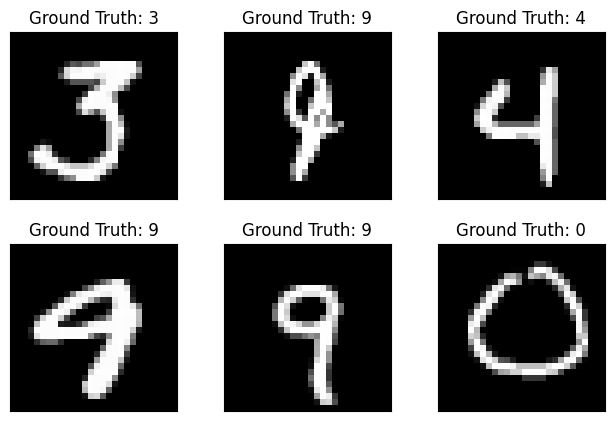

In [40]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
# fig

## Building the Network

In [41]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [42]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

Note: If we were using a GPU for training, we should have also sent the network parameters to the GPU using e.g. ```network.cuda()```. It is important to transfer the network's parameters to the appropriate device before passing them to the optimizer, otherwise the optimizer will not be able to keep track of them in the right way.

In [43]:
# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
network = Net().to(device)
# network.cuda()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

## Training the Model

In [44]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [45]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad() # zero out gradients since pytorch accumulates gradients
        data = data.to(device)
        target = target.to(device)
        output = network(data) # evaluate
        loss = F.nll_loss(output, target) # negative log-likelihood loss btw network output from data and target
        loss.backward() # calc gradients
        optimizer.step() # back prop gradients
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), os.path.join(MODEL_DIR,'model.pth'))
            torch.save(optimizer.state_dict(), os.path.join(MODEL_DIR,'optimizer.pth'))

Do a test run to see what accuracy is like with randomly initialized weights:

In [46]:
# import pdb;
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            output = network(data) # evaluate
            # print(output)
            test_loss += F.nll_loss(output, target, size_average=False).item() # all nll loss
            pred = output.data.max(1, keepdim=True)[1] # predictions
            correct += pred.eq(target.data.view_as(pred)).sum() # calc correct
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      100. * correct / len(test_loader.dataset)))

test()

/tmp/ipykernel_2097712/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
/home/bearceb/.pyenv/versions/3.10.4/envs/mnist/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3096, Accuracy: 924/10000 (9%)



In [47]:
# Train
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.331797


/tmp/ipykernel_2097712/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/60000 (1%)]	Loss: 2.303324
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.266475
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.272787
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.261453
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.231299
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.225890
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.222582
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.114448
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.042787
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.954830
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.993595
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.803929
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.503854
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.452519
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.505873
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.320353
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.361758
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.433705
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.004369
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.138128
Train Epoch: 1 [13440/60

## Evaluating the Model's Performance

Text(0, 0.5, 'negative log likelihood loss')

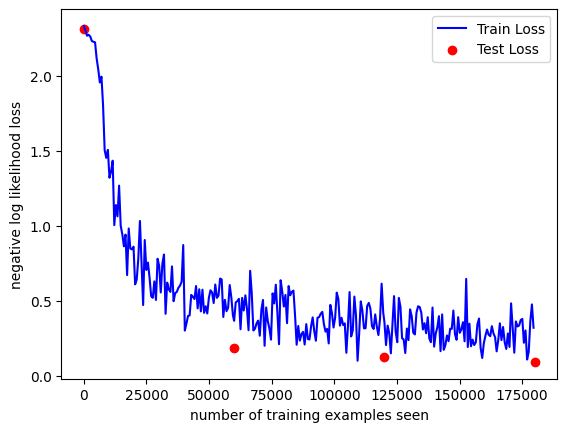

In [48]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
# fig